# Autoencoders

#### Ich habe mein Bestes getan, um die Trainingszeit zu minimieren. Ich hatte ein bereits trainiertes Modell gespeichert. Allerdings spielt der Server nicht mit. Deswegen am besten beim Training einfach eine Stunde lang etwas anderes machen. Man muss nicht 100 Epochen trainieren, sondern kann das Training über Kernel > Interrupt Kernel vorzeitig beenden.
---
**Lernziele**
- Sie verstehen das Konzept eines Autoencoders
- Sie verstehen, wie ein RNN Smiles erzeugen kann
- Sie können ein Netzwerk auch als PyTorch-Class definieren
- Du verstehst die Bedeutung der `<sos>`/`<eos>`-Tokens 
---

Im heutigen Notebook beschäftigen wir uns mit den sogenannten **Autoencodern**.
Autoencoder werden meist durch selfsupervised Training trainiert.
Zur Erinnerung: selfsupervised Training bezieht sich auf das Training von neuronalen Netzen, bei denen Input und Output identisch sind. Das Ziel besteht also darin, die Input wiederherzustellen. 

Aber was ist der Mehrwert eines Netzes, das nur den Input wiederherstellt?
In der Tat sind wir nicht unbedingt an dem Output eines Autoencoders interessiert. Uns interessiert vielmehr, was in der Mitte des Netzes passiert. 
Das liegt daran, dass das eigentliche Ziel von Autoencodern darin besteht, die Daten zu komprimieren, d. h. sie so effektiv wie möglich darzustellen.

Das Beispielbild zeigt einen Autoencoder für Bilder:



<img src="https://d3i71xaburhd42.cloudfront.net/b1786e74e233ac21f503f59d03f6af19a3699024/2-Figure1-1.png" >

*Yifei Zhang - A Better Autoencoder for Image: Convolutional Autoencoder * **2018**


Ein Autoencoder besteht aus zwei Netzwerken, einem **Encoder** und einem **Decoder**. Die Output des Encoders wird als Input für den Decoder verwendet. Der Encoder soll lernen, die Daten so effektiv wie möglich in einem niedrigdimensionalen Raum (latenter Space) zu repräsentieren. Diese Darstellung ist in der Regel einfach ein Vektor, der auch als **latenter Vektor** bezeichnet wird. Der Decoder wird darauf trainiert, den ursprünglichen Input anhand dieses latenten Vektors wiederherzustellen. 

Wir können selbst bestimmen, wie groß der latente Vektor sein soll. Meistens wird eine besonders kleine Größe gewählt, um eine größere Kompression zu gewährleisten.
Nach erfolgreichem Training sollte der *latente Vektor* trotz seiner geringen Größe genügend Informationen enthalten, um das Bild wieder vollständig auszugeben. Das bedeutet, dass dieser Vektor ausreichend informativ ist, um das komplette Bild zu beschreiben. Tatsächliche Anwendungen gehen über die einfache Rekonstruktion hinaus.

Zum Beispiel werden Autoencoder eingesetzt, um die Qualität von Bildern zu verbessern. Dazu werden niedrig aufgelöste Bilder als Input verwendet, und der Output ist das gleiche Bild in seiner regulären (höheren) Auflösung. Auf diese Weise werden Netzwerke trainiert, die später niedrig aufgelöste Bilder schärfen können. 


<img src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60bcd0b7b750bae1a953d61d_autoencoder.png" width ="400px">

*Hmrishav Bandyopadhyay - An Introduction to Autoencoders: Everything You Need to Know* **2021**

Autoencoder gibt es nicht nur für Bilder, sondern auch für Text. RNNs werden für diesen Zweck verwendet. 
Im letzten Notebooks haben wir bereits besprochen, dass der letzte Hidden State eines RNNs eine Zusammenfassung der gesamten Inputsequenz ist. Im Beispiel der Hidden State $O_5$


<img src="https://miro.medium.com/max/724/1*1U8H9EZiDqfylJU7Im23Ag.gif">

*Michael Phi - An illustrated Guide to Recurrent Neural Networks*


Der Output $O_5$ kann bereits als eine Projektion des gesamten Satz in den laten Space verstanden werden. Der Hidden State $O5$ ist also der latente Vektor, der unsere Sequenz beschreibt. Dementsprechend ist das Netzwerk, das diesen Vektor erzeugt hat, auch unser Encoder. Für unseren Autoencoder fehlt also nur noch der Decoder, der aus dem latenten Vektor den ursprünglichen Satz wiederherstellen kann. Wie das genau funktioniert, werden wir anhand eines Beispiels mit Smiles diskutieren.

In [14]:
import pandas as pd
import numpy as np
np.random.seed(1234)
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import sys
from os.path import exists, isdir
import os 
if 'google.colab' in sys.modules:
    !pip install rdkit==2022.3.4
    if exists("utils.py") == False:
        !wget https://raw.githubusercontent.com/kochgroup/intro_pharma_ai/main/utils/utils.py
    if exists("load_fragments.ipynb") == False:
        !wget https://raw.githubusercontent.com/kochgroup/intro_pharma_ai/main/utils/load_fragments.ipynb
    %run utils.py
    %run ../utils/load_fragments.ipynb
else:
    %run ../utils/utils.py
    %run ../utils/load_fragments.ipynb
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')  

Diese Woche benutzen wir einen Datensatz der sich aus einem kleinen Teil der, von der Reymond Gruppe entwickelten, GDB 11 besteht. Nur besonders kleine Moleküle werden hier verwedent. Für uns ist das besonders wichtig, da die Moleküle nicht zu groß werden dürfen. Es ist grundsätzlich schwierig, aus einem latenten Vektor einen gültigen Smiles String zu erzeugen. Je länger die Smiles Strings werden, desto komplexer wird die Aufgabe für das Netzwerk.

Diese Woche liegen die Moleküle auch in einem anderen Dateiformat vor. Im Format `.sdf` werden die Moleküle mit mehr Details gespeichert. Zum Beispiel können hier auch Informationen über die Konformation gespeichert werden. 

---
Fink, T., & Reymond, J. L.. Virtual exploration of the chemical universe up to 11 atoms of C, N, O, F: assembly of 26.4 million structures (110.9 million stereoisomers) and analysis for new ring systems, stereochemistry, physicochemical properties, compound classes, and drug discovery. J. Chem. Inf. Model. **2007** 47(2), 342-353.

---

```

  Mrv0541 07182119162D          

 12 12  0  0  0  0            999 V2000
    0.7145    2.0625    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145    1.2375    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4289    0.8250    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4289   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.1434   -0.4125    0.0000 F   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145   -0.4125    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145   -1.2375    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4289   -1.6500    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0000   -1.6500    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7145   -0.4125    0.0000 F   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.8250    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0  0  0  0
  2  3  4  0  0  0  0
  3  4  4  0  0  0  0
  4  5  1  0  0  0  0
  4  6  4  0  0  0  0
  6  7  1  0  0  0  0
  7  8  2  0  0  0  0
  7  9  1  0  0  0  0
  6 10  4  0  0  0  0
 10 11  1  0  0  0  0
 10 12  4  0  0  0  0
  2 12  4  0  0  0  0
M  END
>  <Catalog ID>
Z1255462241

>  <PlateID>
1225133-R3-01

>  <Well>
A02

>  <MW (desalted)>
172.129

>  <CLogP>
2.082

>  <HBD>
1

>  <TPSA>
37.300

>  <RotBonds>
1

```
Sie sehen auch zusätzliche Informationen wie TPSA oder LogP können gleich mit gespeichert werden.

Um so eine `.sdf` Datei in Python einzulesen, brauchen wir einen sogenannten `MolSupplier` von `rdkit`. Ein Supplier stellt die Verbindung zwischen unsere Datein und Python her. Mit einem `for-loop` können dann die einzelnen Smiles aus dem SDF-File gelesen werden.

In [15]:
suppl = Chem.SDMolSupplier("../data/high_fidelity/fragments.sdf")

In [16]:
smiles = []
for mol in suppl:
    smiles.append(Chem.MolToSmiles(mol)) 
smiles[:10]

['CCCCCCC(=O)OCCC',
 'CC(C)=CCCC(C)C1CCC(C)CC1',
 'CCCCC(C)CC',
 'O=C([O-])C=Cc1ccc(O)cc1',
 'O=C1CCCCCCCCCCCCCCO1',
 'Oc1ccccc1-c1ccccc1',
 'CSCCCO',
 'CC1=CC(=O)C2CC1C2(C)C',
 'CCCCCCOC=O',
 'C=CCCCCCCCCCCCCC']

Wie Sie sehen, ist dies eine weitere Möglichkeit, aus den `.sdf`-Dateien Smiles zu erzeugen.

Außerdem können wir die Strukturen einmal anzeigen, um ein besseres Gefühl für die Art der Fragmente zu bekommen.

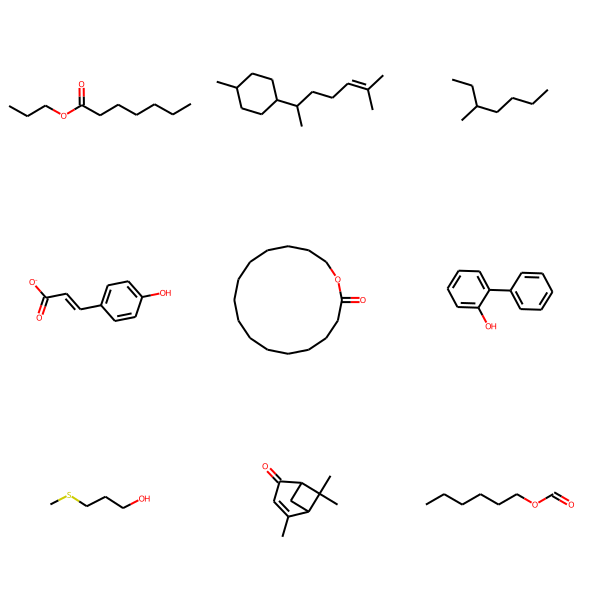

In [17]:
MolsToGridImage([Chem.MolFromSmiles(x)for x in smiles[:9]])

In [18]:
len(smiles)

1675

Insgesamt haben wir 1675 Moleküle im Datensatz.

Wenn Sie sich die Smiles genau ansehen, fällt Ihnen dann etwas auf?

In [19]:
smiles

['CCCCCCC(=O)OCCC',
 'CC(C)=CCCC(C)C1CCC(C)CC1',
 'CCCCC(C)CC',
 'O=C([O-])C=Cc1ccc(O)cc1',
 'O=C1CCCCCCCCCCCCCCO1',
 'Oc1ccccc1-c1ccccc1',
 'CSCCCO',
 'CC1=CC(=O)C2CC1C2(C)C',
 'CCCCCCOC=O',
 'C=CCCCCCCCCCCCCC',
 'CCC(=O)[O-]',
 'C=CC=CC=CCCCCC',
 'C=CCCCCCCCCC=O',
 'CC1=C(C=O)C(C)(C)CC=C1',
 'CCC=O',
 'Cc1ccc2c(c1)C(C(C)C)CCC2C',
 'CC(C)CC(=O)OC1CCCCC1',
 'CC(=O)C=CC12OC1(C)CC(O)CC2(C)C',
 'CCC(=O)CC',
 'COc1ccc2ccccc2c1',
 'CCCCCCCCC1=CCC(=O)O1',
 'C=CC(C)(CCC=C(C)C)OC(=O)CC',
 'CC(C)C12C=CC(C)(O)C1C2',
 'COC(=O)CSC',
 'CCC=CCCO',
 'CCCCCCCCCCCCCC(=O)[O-]',
 'C=C1CCC2CC1C2(C)C',
 'CCC(C=O)CC',
 'CC(C)=CCCC(C)=CCCc1ccoc1',
 'CC(C)CC(=O)OCCc1ccccc1',
 'CC(C)=C1CCC(C)CC1=O',
 'CCCCC(=O)OCC=C(C)CCC=C(C)C',
 'COc1cccc2c(N)c(C)cnc12',
 'CC=CC=CC(=O)OCC',
 'COc1c(C)o[c-](C)c1=O',
 'CC=CC=CC(=O)OC',
 'Cc1nc(-c2cc(C(=O)O)oc2C)cs1',
 'C=CCc1cc(OC)c(O)c(OC)c1',
 'CC(C)CCOC(=O)CC(C)C',
 'O=C1CCCO1',
 'Nc1ccc(N2CCCCC2)cn1',
 'C=CCc1ccc(O)c(OC)c1',
 'CC1CCCC(=O)C1',
 'CC1CCC2C1C1C(CCC2(C)O)C1(C)C

Ein Problem ist, dass die Stereoinformationen immer noch in den Smiles enthalten sind. Zum Beispiel das `@`-Symbol. Ein weiteres Problem ist das `.`. Dieses markiert den Beginn eines weiteren Moleküls. In unserem Fall sind es aber eigentlich nur `Cl`-Atome, die sich noch in einigen Smiles befinden. 
Zum Beispiel die Moleküle 61.

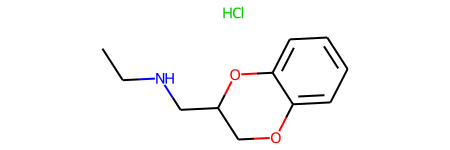

In [20]:
Chem.MolFromSmiles(smiles[60])

Wir können die Stereoinformationen sowie die "zusätzlichen" Moleküle durch String-Manipulationen entfernen.

`string.replace("@", "")`

durchsucht den `string` nach dem Zeichen `@` und wenn es eines findet, werden sie durch `""` ersetzt, werden also einfach entfernt.


*Alternativ kann auch folgender Code benutzt werden:*

```python
Chem.MolToSmiles(Chem.MolFromSmiles("N[C@@H](C)C(=O)O"),isomericSmiles=False)
```
Die option `isomericSmiles = False` wurde erst später zu RDKit hinzugefügt.


`string.split(".")`

teilt den `string` an jedem `"."` auf. Die Funktion gibt die einzelnen Teilstrings als Liste aus.

In [21]:
"Schoko.l@de".replace("@", "").split(".")

['Schoko', 'lde']

In [22]:
sub_molecules = []
for smile in smiles:
    smile = smile.replace("@", "")
    smile = smile.replace("\\", "")
    sub_molecules.append(smile.split("."))

Im nächsten Schritt müssen wir nur noch die Moleküllisten durchgehen. Wenn ein Smiles aus mehreren Molekülen besteht, wählen wir einfach das größte Molekül als das richtige aus.

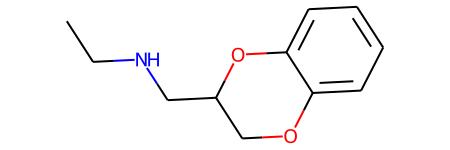

In [23]:
filtered_smiles =[]
for mol_list in sub_molecules:
    filtered_smiles.append(mol_list[np.argmax([len(x) for x in mol_list])])
    
Chem.MolFromSmiles(filtered_smiles[60])

Das 61ste Moleküle beinhaltet jetzt nicht mehr das zusätzlichen `HCl`.

Die Smiles sind nun "sauber" und wir können damit beginnen, sie für das RNN vorzubereiten. Erstellen Sie also einen Dictionary und ersetzen Sie die Smiles durch Tokens. Zuerst verwenden wir wieder die Funktion `creat_dict`, um ein Dictionery für unsere Daten zu erstellen. Aber dieses Mal verwenden wir auch den Parameter `add_tokens = True`:

In [25]:
dictionary = create_dict(filtered_smiles, add_tokens =True)
dictionary

{'<sos>': 0,
 '<eos>': 1,
 '<pad>': 2,
 '#': 3,
 '(': 4,
 ')': 5,
 '-': 6,
 '/': 7,
 '1': 8,
 '2': 9,
 '3': 10,
 '4': 11,
 '=': 12,
 'C': 13,
 'Cl': 14,
 'F': 15,
 'H': 16,
 'N': 17,
 'O': 18,
 'S': 19,
 '[': 20,
 ']': 21,
 'c': 22,
 'n': 23,
 'o': 24,
 's': 25}

Es wurden 3 neue Tokens hinzugefügt, die in den Smiles nicht vorkommen.

- Sie kennen bereits `<pad>`. Er wird verwendet, um alle Smiles auf die gleiche Länge zu bringen.

- `<sos>` ist ein Token, der den Beginn eines Smiles ankündigt. "Start of Sentence". Dieses Token wird **vor** jeden Smiles gesetzt.

- `<eos>` zeigt das Ende des Smiles an. Nachdem der eigentliche Smiles vorbei ist, folgt der Token `<eos>` und dann die Padding Token.

Alle unsere Smiles sollten also wie folgt aussehen:

```python
"<sos>OCc1ccc2occc2c1<eos><pad><pad>"
```


Warum ist das notwendig? Warum werden diese speziellen Token benötigt?

Das liegt daran, wie ein Decoder in einem RNN funktioniert. 

Noch einmal zur Erinnerung: So sieht unser Modell aus:

<img src="Img/rnn/auto_1.png" width ="400px">

Den Encoder haben wir quasi letzte Woche geschrieben, jetzt müssen wir uns nur noch auf den Decoder konzentrieren.
Die Grundidee eines Decoder-RNN ist, dass die SMILES Token für Token nacheinander erzeugt werden.

Beispiel:

Der Decoder erhält den latenten Vektor vom Encoder:
Darauf erzeugt er ein `C`. Nun kann der Decoder mit Hilfe des latenten Vektors und des bereits erzeugten `C` ein weiteres `C` erzeugen. Dann ist unser aktueller Smiles `CC`. Nun wird der Schritt noch einmal wiederholt, mit dem Wissen des latenten Vektors und den bereits zwei `CC`.
Jetz kann der Decoder  z.B. ein `=` erzeugen: `CC=` usw...
Theoretisch könnte dies unendlich so weitergehen. Deshalb gibt es ein `<eos>`-Token. Dieses Token erlaubt es dem Netzwerk, den Smiles zu beenden, wenn es denkt, dass dieser komplett ist.

Im Folgenden wird es ein wenig theoretischer:

Um es genauer zu verstehen, wiederholen wir kurz, wie ein RNN funktioniert.

Ein RNN hat immer zwei Inputs. Einer ist die normale Eingabe, d.h. das aktuelle Token (Smile-Symbol), für das eine Vorhersage gemacht werden muss.
Zusätzlich wird ein Hidden State aus dem vorherigen Schritt übernommen. Also die Ausgabe des RNN für den vorherige Token.

Durch den Encoder erhalten wir bereits den latenten Vektor, der unser anfänglicher Hidden State für den Decoder sein wird. 

<img src="Img/rnn/auto_3.png" width ="400px">

Doch was ist unser initialer Input?

<img src="Img/rnn/auto_4.png" width ="400px">

Das Problem ist, wenn wir den tatsächlich ersten Token des originalen Smiles als ersten Token für den Decoder verwenden, ist es relativ leicht diesen richtig zu vorhersagen. Deshalb verwenden wir zuerst den Token `<sos>` als ersten Input für den Decoder. Dieses Token enthält keine Informationen über den Inputsmiles. Das heißt, der erste Token wird nur auf der Grundlage des Hidden State oder dem latent Vektor vorhergesagt. Wichtig ist auch, dass die Ausgabe des RNN (der neue Hidden State) zunächst eine lineare Schicht durchläuft, die dann den richtigen Token vorhersagt.
<img src="Img\rnn\auto_6.png" width ="400px">

Im nächsten Schritt ersetzt der neue Hidden State den latent Vektor als Input für den nächsten Schritt. Auch wird nicht mehr ein Token des ursprünglichen Smile als Input verwendet, sondern der Token, der im vorherigen Schritt vorhergesagt wurde. 
Das heißt, selbst wenn der Decoder am Anfang einen Fehler macht, rechnet er mit diesem Fehler weiter.
<img src="Img\rnn\auto_7.png" width ="400px">

Wir wiederholen dies, bis wir die Länge des längsten Smiles in unserem Datensatz erreicht haben. Natürlich sind die meisten Smiles nicht so lang, also können wir den `<eos>` Token verwenden. Damit kann der Smiles vorher beendet werden. 
<img src="Img/rnn/auto_8.png" width ="400px">

Wenn wir in der Funktion `tokenize` ` (..., add_tokens=True)` verwenden, werden `<sos>` und `<eos>` automatisch zu jedem Smile hinzugefügt. Die `0` steht im `dictionary` für `<sos>` und die `1` für `<eos>`.

In [37]:
tokenized_smiles = tokenize(filtered_smiles,dictionary, add_tokens =True)
tokenized_smiles[7]

[0,
 12,
 12,
 8,
 11,
 12,
 12,
 4,
 11,
 17,
 5,
 12,
 9,
 12,
 12,
 8,
 12,
 9,
 4,
 12,
 5,
 12,
 1]

Die Smiles sind immer noch alle unterschiedlich lang. Wir berechnen zunächst die Anzahl der Token in jedem Smiles.

In [38]:
token_lengths = np.array([len(x) for x in tokenized_smiles])
max_length=max(token_lengths)
max_length

26

Wir können die Anzahl der Token auch mit einem Histogramm darstellen. Das Problem ist, je mehr Token ein Smiles hat, desto schwieriger ist es für den Decoder, den komplette Smiles wiederherzustellen.

(array([  2.,   3.,   3.,   5.,   6.,  24.,  33.,  48.,   0.,  59.,  71.,
         67.,  75., 105., 106., 115.,   0., 123., 120., 123.,  96., 101.,
         64.,  51.,  43.]),
 array([ 4.  ,  4.88,  5.76,  6.64,  7.52,  8.4 ,  9.28, 10.16, 11.04,
        11.92, 12.8 , 13.68, 14.56, 15.44, 16.32, 17.2 , 18.08, 18.96,
        19.84, 20.72, 21.6 , 22.48, 23.36, 24.24, 25.12, 26.  ]),
 <BarContainer object of 25 artists>)

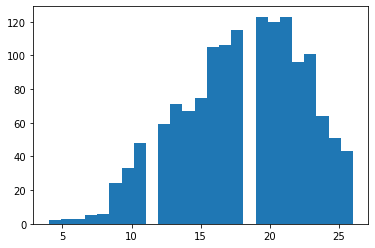

In [39]:
plt.hist(token_lengths, bins=25)

Wir könnten zum Beispiel alle Moleküle aus dem Datensatz herauswerfen, die aus mehr als 26 Token bestehen.

In [40]:
np.sum(token_lengths>26)

0

Das sind genau 232 Moleküle. Das ist natürlich nicht ideal, aber es hilft uns beim Training. Gerade mit so wenigen Daten ist es schwierig, einen Autoencoder zu trainieren. Wir entfernen diese Moleküle dennoch aus dem Datensatz.

In [41]:
filtered_smiles=np.array(filtered_smiles)[token_lengths<=26].tolist()
len(filtered_smiles)

1443

Mit den reduzierten Daten erstellen wir einen neuen Dictionary und tokenisieren unsere Daten.

In [42]:
dictionary = create_dict(filtered_smiles, add_tokens =True)
tokenized_smiles = tokenize(filtered_smiles,dictionary, add_tokens =True)
tokenized_smiles[:5]

[[0, 12, 12, 12, 12, 12, 12, 12, 4, 11, 17, 5, 17, 12, 12, 12, 1],
 [0,
  12,
  12,
  4,
  12,
  5,
  11,
  12,
  12,
  12,
  12,
  4,
  12,
  5,
  12,
  8,
  12,
  12,
  12,
  4,
  12,
  5,
  12,
  12,
  8,
  1],
 [0, 12, 12, 12, 12, 12, 4, 12, 5, 12, 12, 1],
 [0,
  17,
  11,
  12,
  4,
  19,
  17,
  6,
  20,
  5,
  12,
  11,
  12,
  21,
  8,
  21,
  21,
  21,
  4,
  17,
  5,
  21,
  21,
  8,
  1],
 [0,
  17,
  11,
  12,
  8,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  17,
  8,
  1]]

In [43]:
token_lengths = np.array([len(x) for x in tokenized_smiles])
max_length=max(token_lengths)
max_length

26

Alle unsere Smiles bestehen nun aus maximal 26 Zeichen. In einem letzten Schritt müssen wir die Smiles, die nicht aus 26 Tokens bestehen, auf die richtige Länge bringen. Dazu verwenden wir das `<pad>`-Token.

In [44]:
for i, tok_smi in enumerate(tokenized_smiles):
    tokenized_smiles[i] = tok_smi+ [dictionary["<pad>"]]*(max_length - token_lengths[i])

Im letzten Schritt wandeln wir die Listen der Tokens in einen `tensor` um.

In [45]:
tokenized_smiles=torch.tensor(tokenized_smiles, dtype=torch.long)
tokenized_smiles[:5]

tensor([[ 0, 12, 12, 12, 12, 12, 12, 12,  4, 11, 17,  5, 17, 12, 12, 12,  1,  2,
          2,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 12, 12,  4, 12,  5, 11, 12, 12, 12, 12,  4, 12,  5, 12,  8, 12, 12,
         12,  4, 12,  5, 12, 12,  8,  1],
        [ 0, 12, 12, 12, 12, 12,  4, 12,  5, 12, 12,  1,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 17, 11, 12,  4, 19, 17,  6, 20,  5, 12, 11, 12, 21,  8, 21, 21, 21,
          4, 17,  5, 21, 21,  8,  1,  2],
        [ 0, 17, 11, 12,  8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 17,  8,  1,  2,  2,  2,  2]])

## Modell

Heute werden wir nicht `nn.Sequential`  verwenden, um unser Modell zu erstellen. Für einfache Architekturen bietet sich `nn.Sequential` an. Allerdings ist es nicht sehr flexibel. 
Deshalb werden die meisten Netzwerke in PyTorch "von Hand" geschrieben.

Wie das gemacht wird, wollen wir uns heute ansehen:

Es gibt zwei Prozesse, die ein Netzwerk in PyTorch eigentlich immer ausführen muss:

1. es muss die notwendigen Weights initialisieren 
2. es muss den Input durch das Netz leiten

Die Initialisierung bei `nn.Sequential()` wird automatisch bei der Erstellung des Modells durchgeführt.

In [46]:
model = nn.Sequential(nn.Linear(10,20), nn.ReLU(), nn.Dropout(0.2), nn.Linear(20,1))
model 

Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=20, out_features=1, bias=True)
)

In [47]:
list(model.parameters())[1]

Parameter containing:
tensor([-2.6083e-01,  2.0385e-05, -1.3858e-02,  2.3586e-01, -1.9561e-01,
         7.4813e-02, -1.8974e-01, -2.7520e-01, -6.1202e-02, -2.9723e-01,
         1.0674e-02,  2.4670e-01,  8.5706e-02, -1.6648e-01,  2.1828e-01,
        -1.3164e-01,  1.5726e-01,  1.3764e-01,  2.5737e-01, -1.7958e-01],
       requires_grad=True)

Auf diese Weise haben wir unsere Netze bisher definiert. Jede Layer ist automatisch
erstellt und die Weights zufällig initialisiert.

Wir können aber auch unser eigenes Netzwerk selbst definieren.
Dazu müssen wir eine PyTorch-Klasse erstellen. Klassen in Python sind ähnlich wie Funktionen. Nur können Klassen auch Eigenschaften und eigene Funktionen enthalten. Wir werden hier nicht auf die genauen Funktionalitäten von Klassen eingehen.

Wichtig ist nur, dass wir auch Klassen erstellen können, die sich wie PyTorch-Klassen verhalten.
Dazu schreiben wir zunächst den folgenden Code:

``` python
class einfaches_nn(nn.Module):
```


Damit legen wir fest, dass die Klasse `einfaches_nn` eine Klasse ist, die zu `nn.Module` gehört. Wie andere Layers oder Modelle in PyTorch sollte sie also zu `nn` gehören bzw. ähnlich funktionieren.

Als nächstes kommt die Initialisierung 

``` python
class einfaches_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
```

`def __init__(self,input_dim, hid_dim, out_dim, dropout):` ist eine Funktion, die bei der Initialisierung des Netzes aufgerufen wird. Also zum Beispiel `model = einfaches_nn`. Automatisch wird dann ausgeführt was in der `__init__` Funktion steht. Es ist wichtig, dass neben den Dimensionen, die die Größe des Netzes bestimmen, auch ein `self` als Input angegeben wird.

`self` "enthält" alle Informationen, die für diese Klasse gespeichert werden (sollen). Diese können auch über die Funktion hinaus benutzt werden. Das sollte in ein paar Minuten deutlicher werden.

`super().__init__()` ist Teil des Codes der wichtig für PyTorch Klassen ist. Dieser Teil darf nicht in der Initialisierung fehlen.

Als Nächstes können wir unsere linear Layers und Dropout in `self` "speichern":

``` python
class einfaches_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
        
        self.ln1 = nn.Linear(input_dim, hid_dim)
        self.ln2 = nn.Linear(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
```

`self.ln1 = nn.Linear(input_dim, hid_dim)` erlaubt es uns, später in andere Funktionen die erste linear Layer mit `self.ln1` auszuwählen

In [48]:
class einfaches_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
        
        self.ln1 = nn.Linear(input_dim, hid_dim)
        self.ln2 = nn.Linear(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

In [49]:
model_2 = einfaches_nn(input_dim=10,hid_dim= 20, out_dim=1, dropout=0.2)
model_2

einfaches_nn(
  (ln1): Linear(in_features=10, out_features=20, bias=True)
  (ln2): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Wir können sehen, dass das Netz auch aus den richtigen Layers besteht, aber in der falschen Reihenfolge. Auch die ReLU-Funktion fehlt. Das ist bisher nicht weiter schlimm, denn die Funktion `__init__` soll das Modell nur initialisieren, also nur die Schichten und deren Weights erzeugen. ReLU hat keine Gewichte und muss daher nicht "initialisiert" werden.

Hier ist auch der Beweis, dass das Netzwerk `Modell_2` jetzt zufällige Weights hat.

In [50]:
list(model_2.parameters())[1]

Parameter containing:
tensor([-0.1202,  0.1244,  0.2792, -0.2712, -0.0346,  0.2850, -0.0562,  0.1046,
        -0.0752,  0.0883,  0.0926,  0.3031,  0.1031,  0.1778, -0.1059,  0.1877,
        -0.1116, -0.1704, -0.3053, -0.2570], requires_grad=True)

Wir können auch probieren, ob die Model von einem Input (`fake_input` enthält zufällige Zahlen) einen Output generieren kann.

In [51]:
fake_input = (torch.rand(10))

model(fake_input)

tensor([0.0257], grad_fn=<AddBackward0>)

Für das `nn.Sequential` Modell kein Problem.

In [52]:
fake_input = (torch.rand(10))

model_2(fake_input)

NotImplementedError: 

Der Fehler 
```python
raise NotImplementedError
```
wird ausgegeben. Das bedeutet, dass wir diesen Teil des Modells noch nicht implementiert haben, d.h. wir haben ihn noch nicht in der Klasse definiert.

Bis jetzt kann `simple_nn` nur die Weights initialisieren. Aber es weiß noch nicht, wie es die Inputs durch das Netz leiten soll.
In `nn.Sequential` wird dies automatisch gemacht. Der Input wird einfach nacheinander durch die Layer geleitet. Die Reihenfolge ergibt sich aus der Reihenfolge dieser Layers bei der Initialisierung. 

Damit das für unsere eigene Klasse funktioniert, benötigen wir eine weitere Funktion namens 

```python
def forward(self, x):
```
`forward` ist, wie der Name andeutet, für die Forward Propagation zuständig. Es legt fest in welcher Reihnfolge Input `x` durch die zuvor definierten Layers geführt wird.
Es ist auch wichtig zu beachten, dass `self` ein weiterer Input neben `x` ist. `self` enthält alle Informationen, die wir bereits in `__ìnit__` definiert haben.

```python
class einfaches_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
        
        self.ln1 = nn.Linear(input_dim, hid_dim)
        self.ln2 = nn.Linear(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x):
        x = self.ln1(x)
        x = self.dropout(x)
        x = nn.functional.relu(x)
        output = self.ln2(x)
        return output
```


Hier geben wir Schritt für Schritt an, was mit dem ursprünglichen Input passieren soll. Im ersten Schritt wird `x` durch die erste lineare Layer geführt. Diese wurde in `self.ln1` gespeichert. Nur für die Aktivierungsfunktion brauchen wir `self` nicht, da diese auch nicht initialisiert wurde.

---
**Wichtig ist auch, dass wir jetzt nicht mehr** `nn.ReLU` **verwenden können, sondern wir müssen** `.nn.functional.relu()` **benutzen.**

---

In [53]:
class einfaches_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
        
        self.ln1 = nn.Linear(input_dim, hid_dim)
        self.ln2 = nn.Linear(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x):
        x = self.ln1(x)
        x = self.dropout(x)
        x = nn.functional.relu(x)
        output = self.ln2(x)
        return output
    
model_2 = einfaches_nn(input_dim=10,hid_dim= 20, out_dim=1, dropout=0.2)
model_2    

einfaches_nn(
  (ln1): Linear(in_features=10, out_features=20, bias=True)
  (ln2): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

An der Initialisierung hat sich nichts geändert, aber wir können jetzt Input durch das Netzwerk führen.

In [54]:
model_2(fake_input)

tensor([0.3301], grad_fn=<AddBackward0>)

Wir können also komplexere Netzwerke designen, die nicht nur einen Input haben.

## Encoder

Nun zurück zu unserem Autoencoder.
Zuerst definieren wir den Encoder.
Wir haben eine `nn.Embedding` Layer und eine `nn.GRU` Layer. Der Encoder ist genau so aufgebaut wie das RNN im letzten Notebook, nur dass wir das Netzwerk hier explizit selbst schreiben.

Sehen Sie sich die Funktion `forward` an. Als Input nimmt sie eine `input_seq`, das ist eine Folge von Tokens. Die Output ist der letzte `hidden` State des Netzes. Dieser beschreibt den komplette Smiles und ist gleichzeitig unser latenter Vektor.

In [55]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim 
        self.embedding = nn.Embedding(input_dim, emb_dim) 
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_seq):
        embedded = self.dropout(self.embedding(input_seq))
        outputs, hidden = self.rnn(embedded) 
        return hidden
    

## Decoder 

Der Decoder ist schon etwas komplexer.  Wenn Sie nicht den gesamten Code verstehen, ist das in Ordnung. Solange Sie dem allgemeinen Konzept folgen können.
Wieder haben wir eine `Embedding` Layer und eine `GRU` Layer, zusätzlich gibt es noch eine Linear Layer. Diese bestimmt anhand des Hidden States welcher Token generiert werden soll.

Im `forward` Pass gibt es zwei Inputs. Einmal den `input`, das ist der letzte Token, der vorhergesagt wurde. Am Anfang ist das der`<sos>` Token. `hidden` ist der Hidden State des `GRU` aus dem vorherigen Schritt.
`forward` gibt sowohl die `prediction`, der vorhergesagte Token, als auch `hidden`, den neuen Hidden State, aus.

In [56]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden):
        
        input = input.unsqueeze(0)
        
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output[0])
        
        return prediction, hidden

Schließlich führen wir beide Komponenten in einem `Autoencoder` zusammen. Als Input nimmt dieses Modell einen Decoder und einen Encoder.  Der Autoencoder hat auch seinen eigenen `forward` Pass. Zunächst wird der Input durch den Encoder geschickt. Der Encoder gibt uns den Hidden State `hidden`. Dieser Hidden State wird dann einmal zu Beginn des `for-loops` für den Decoder verwendet. Außerdem nehmen wir die erste Zeile von `output_seq` als erste Input für den Decoder. Diese Zeile besteht aus den `<sos>`-Tokens.

Wir verwenden auch Teacher Forcing. Teacher Forcing wird beim Training verwendet, um es dem Decoder zu erleichtern, den vollständigen Smiles wiederherzustellen. Wenn der Decoder einen falschen Token am Anfang eines Smiles vorschlägt, muss der Decoder mit diesem falschen Token als Input  weiterrechnen. Dies kann vor allem zu Beginn des Trainings ein Problem darstellen, da hier viele Fehler gemacht werden. Durch Teacherforcing wird der vorhergesagten Token durch den richtigen Token ersetzt. So kann der Decoder mit dem richtigen Token weiterrechnen. Bei der Evaluierung wird das Teacher-Forcing dann ausgeschaltet. 

In [72]:
  
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder

        
    def forward(self, input_seq, output_seq, teacher_forcing_ratio = 0.5):
        
        # speichern von Parametern
        batch_size = output_seq.shape[1]
        trg_len = output_seq.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size)
        
        
        # Eigentlicher Forward Pass
        
        # Der Encoder berechnet den Hidden State/Latent Vector
        hidden = self.encoder(input_seq)
        
        # Als initialen Input für den Decoder wählen wir die <sos> Tokens aus
        input = output_seq[0,:]
        
        # Der for-loop wird benutzt, um nacheinander die Tokens zu generieren.
        for t in range(1, trg_len):

            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1) 

            input = output_seq[t] if teacher_force else top1

        return outputs

Wie gegesagt, es ist okay wenn Sie in diesem Fall nicht alles verstehen.

Zunächst müssen wir unser Model definieren.

In [73]:
torch.manual_seed(1234)
enc = Encoder(len(dictionary), 128, 256, 0.2)
dec = Decoder(len(dictionary),128,256,0.2)
model = Autoencoder(enc, dec)
model

Autoencoder(
  (encoder): Encoder(
    (embedding): Embedding(25, 128)
    (rnn): GRU(128, 256)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(25, 128)
    (rnn): GRU(128, 256)
    (fc_out): Linear(in_features=256, out_features=25, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

Man kann deutlich die verschiedenen Komponenten des Autoencoders sehen.
Wir erstellen auch noch einen `DataLoader`. Dieser nimmt als $x$ und $y$ die gleiche Sequenz, da wir einen Autoencoder trainieren wollen. Außerdem speichern wir einen Beispielbatch `ex_in` und `ex_out`.

Da wir so wenig Daten haben, verwenden wir keinen Testdatensatz.

In [74]:
train_dataset = TensorDataset(tokenized_smiles, tokenized_smiles)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
ex_in = ex_out = tokenized_smiles[:16,:]

Wir definieren unseren Optimizer und unsere Lossfunktion. Hier können wir auch angeben, dass der Index `2` bei der Berechnung des Loss ignoriert werden soll. Dies ist der Index für den `<pad>` Token. Und dieser ist für die Vorhersage nicht wichtig.

In [75]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = 2)

Der letzte Schritt ist der Trainingsloop. Dieser ist ein normaler `for-loop`, aber wir verwenden die Transponierung der `input_seq` und der `output_seq`. Denn so gehen die Funktionen der Netze leichter ineinander über. 

Im Trainingsloop selbst wird die Qualität der generierten Smiles alle 5 Epochen bewertet. Es wird betwertet wie viele Smiles sind gültig und wie viele Smiles sind tatsächloch identisch mit dem Input.

Dies geschieht durch die Funktion `evaluate()`, die für Sie vorgeschrieben wurde.

In [76]:
random.seed(1234)
for epoch in range(100):
    epoch_loss = 0

    model.train()
    for input_seq, output_seq in train_loader:
        optimizer.zero_grad()        
        
        input_seq = input_seq.t()
        output_seq = output_seq.t()


        output = model(input_seq, output_seq, 0.2)
        
        
        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)
        output_seq =  output_seq[1:].reshape(-1)
        
        loss = criterion(output,  output_seq)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
    if (epoch%5==0):
        valid, correct=evaluate(model, train_loader, dictionary)
        print(f"Epoch {epoch}: Loss: {epoch_loss /len(train_loader)} % Valid: {valid.round(2)} % Correct: {correct.round(2)} ")
    else:
        print(f"Epoch {epoch}: Loss: {epoch_loss /len(train_loader)}")
    

Epoch 0: Loss: 1.8249785284419635 % Valid: 0.69 % Correct: 0.0 
Epoch 1: Loss: 1.450405478477478
Epoch 2: Loss: 1.2465889984434777
Epoch 3: Loss: 1.0798736594535492
Epoch 4: Loss: 0.9573713213532835
Epoch 5: Loss: 0.8667241688613053 % Valid: 0.55 % Correct: 0.08 
Epoch 6: Loss: 0.8410404180432414
Epoch 7: Loss: 0.7773370618348593
Epoch 8: Loss: 0.7207541259435507
Epoch 9: Loss: 0.6542004916694139
Epoch 10: Loss: 0.6677825902844523 % Valid: 0.59 % Correct: 0.19 
Epoch 11: Loss: 0.6034839680561652
Epoch 12: Loss: 0.6061458662971035
Epoch 13: Loss: 0.5679912531113886
Epoch 14: Loss: 0.5356593823039925
Epoch 15: Loss: 0.5235887854308873 % Valid: 0.64 % Correct: 0.36 
Epoch 16: Loss: 0.5096707740327814
Epoch 17: Loss: 0.456692826289397
Epoch 18: Loss: 0.5118140254046891
Epoch 19: Loss: 0.44956426387959786
Epoch 20: Loss: 0.37902350903867366 % Valid: 0.74 % Correct: 0.45 
Epoch 21: Loss: 0.4057903993915726
Epoch 22: Loss: 0.3874324537240542
Epoch 23: Loss: 0.46771246849835574
Epoch 24: Loss:

Jetzt können wir schauen, wie gut unser Model wirklich ist. Während des Trainings benutzen wir immer noch Teacher Forcing. Das wird während der Evaluierung ausgeschaltet.

In [78]:
evaluate(model,train_loader, dictionary)

(0.9690934065934066, 0.9004120879120879)

Unser Autoencoder generiert  tatsächlich valide Smiles. Viele der generierten Smiles sind auch tatsächlich identisch zu den Inputsmiles.

Autoencoder sind schwierig zu trainieren, besonders für Sprachen oder auch Smiles. Die Grammatik von Smiles muss erst erlernt werden. Dafür brauch es eigentlich viel mehr Daten. Darüber hinaus, benutzen wir ein sehr simples Model. Trotzdem können wir und das Netzwerk ein wenig genauer anschauen.

Wir können uns zum Beispiel die Vorhersagen für unseren `ex_in` Batch anschauen.

Wir lassen uns die vorhergesagten Token für die ersten beide Smiles im Batch aus. 

In [79]:
model.eval()
pred = model(ex_in.t(), ex_out.t(), 0)
pred_tokens =pred.argmax(2).t().detach().numpy()

pred_tokens[:2]

array([[ 0, 12, 12, 12, 12, 12, 12, 12,  4, 11, 17,  5, 17, 12, 12, 12,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 0, 12, 12,  4, 12,  5, 11, 12, 12, 12, 12,  4, 12,  5, 12,  8,
        12, 12, 12,  4, 12,  5, 12, 12,  8,  1]], dtype=int64)

Zum Vergleich, die Originaldaten:

In [80]:
ex_out[:2]

tensor([[ 0, 12, 12, 12, 12, 12, 12, 12,  4, 11, 17,  5, 17, 12, 12, 12,  1,  2,
          2,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 12, 12,  4, 12,  5, 11, 12, 12, 12, 12,  4, 12,  5, 12,  8, 12, 12,
         12,  4, 12,  5, 12, 12,  8,  1]])

Die Funktion `token_to_smiles` wandelt die Token wieder in Smiles um:
So sehen die vorhergesagten Smiles aus:

In [81]:
pred_smiles = tokens_to_smiles(pred_tokens,dictionary )
true_smiles = tokens_to_smiles(ex_out.detach().numpy(), dictionary)
pd.DataFrame({"true":true_smiles, "pred": pred_smiles })

,true,pred
0,CCCCCCC(=O)OCCC,CCCCCCC(=O)OCCC
1,CC(C)=CCCC(C)C1CCC(C)CC1,CC(C)=CCCC(C)C1CCC(C)CC1
2,CCCCC(C)CC,CCCCC(C)CC
3,O=C([O-])C=Cc1ccc(O)cc1,O=C([O-])C=Cc1ccc(O)cc1
4,O=C1CCCCCCCCCCCCCCO1,O=C1CCCCCCCCCCCCCCO1
5,Oc1ccccc1-c1ccccc1,Oc1ccccc1-c1ccccc1
6,CSCCCO,CSCCOO
7,CC1=CC(=O)C2CC1C2(C)C,CC1=CC(=O)C2CC1C2(C)C
8,CCCCCCOC=O,CCCCCCOC=O
9,C=CCCCCCCCCCCCCC,C=CCCCCCCCCCCCCC


Tatsächlich sind die meisten Smiles identisch zu dem originalen. Aber es gibt auch abweichende Smiles. Der Smiles mit dem Index 8 ist nicht identisch und ist noch nicht einmal ein valider Smiles.

# Neue Molkeüle generieren

Wir haben einen Decoder, der aus unseren Hidden States/latenten Vektoren gültige Moleküle erzeugen kann. 
Bis jetzt haben wir die latenten Vektoren erhalten, indem wir bekannte Smiles durch den Encoder geschickt haben. Aber was hält uns davon ab, zufällige latente Vektoren zu erzeugen und zu sehen, was der Decoder daraus generiert? Unsere Hidden States latenten Vektoren haben diese Größe:

In [82]:
latent_vectors =  model.encoder(ex_in.t()).detach().numpy()
latent_vectors.shape

(1, 16, 256)

Wir können einfach einen alternativen latenten Vektor `tensor` erstellen. Diesen füllen wir mit zufälligen Zahlen.

In [83]:
torch.manual_seed(5489786)
hidden = torch.randn(1,16,256)

Wir verwenden diesen anstelle des ursprünglichen`tensors` als Input für den Decoder.
Der Decoder sollte nun versuchen, aus diesen Zufallsdaten neue Smiles zu generieren. Da der Hidden State zufällig gewählt wurde, sollte es sich um Moleküle handeln, die noch nicht in unserem Datensatz enthalten sind. Man spricht in solchen Fällen von De-Novo Design.

In [84]:
outputs = torch.zeros(26, 16, len(dictionary))
input_ = ex_out.t()[0,:] #<- ["<sos>"] Tokens
for t in range(1, 26):
    output, hidden = model.decoder(input_, hidden)
    outputs[t] = output
    input_ = output.argmax(1) 



In [85]:
pred_tokens = outputs.argmax(2).t().detach().numpy()
new_smiles = tokens_to_smiles(pred_tokens, dictionary)
new_smiles

['2C(C))CC1',
 'Fccc()SC',
 'C=O)C',
 'OC(C)Cc1',
 'C=CCOO)',
 's(=O)OC',
 'F))s2',
 'C=C',
 '(C=O)CCC',
 'S///C=CCCC2',
 'CCC',
 'No11O',
 'O-])CCc1',
 'ss(C)CCC',
 '[O-]',
 '[O-]1nccs1']

Tatsächlich ist keines dieser Moleküle in unserem Datensatz enthalten. Das liegt aber vorallem daran das die meisten keine gültige Moleküle sind. 
Das Problem besteht hauptsächlich darin, dass der latente Raum, d. h. der gesamte Raum, der durch unsere latenten Vektoren beschrieben werden kann, viel zu groß ist. Es wird sehr schwierig sein, zufällig Zahlen zu finden, die ein gültiges Molekül ergeben.

Um wirklich effektiv Moleküle mit Hilfe von Autoencodern zu erzeugen, benötigen wir viel mehr Daten. So kann die Grammatik der Smiles besser gelernt werden. Auch werden am häufigsten so genannte Variational-Autoencoder (VAE) verwendet. Diese "zwingen" den latenten Raum in einen vordefinierten Raum. Wenn man dann Zufallszahlen wählt, die denselben definierten Raum entsprechen, ist die Wahrscheinlichkeit höher, dass es sich um ein gültiges Molekül handelt.

# Übungsaufgabe

In der heutigen Übung geht es nicht um Autoencoders. Die Aufgabe besteht darin, ein `nn.Sequential`-Modell in eine funktionierende PyTorch-Klasse umzuschreiben.

Das Modell sieht wie folgt aus:

In [ ]:
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit import RDLogger  
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
RDLogger.DisableLog('rdApp.*')      
%run ../utils/utils.py

In [ ]:
model_1 =nn.Sequential(nn.Linear(20,100),
              nn.BatchNorm1d(100),
              nn.ReLU(),
              nn.Dropout(0.2),
              nn.Linear(100,100),
              nn.BatchNorm1d(100),
              nn.ReLU(),
              nn.Linear(100,10))
model_1

Schreiben Sie das Modell um. Beachten Sie, dass `nn.ReLU` nicht in `forward` funktioniert. Hier verwenden Sie bitte `nn.functional.relu()`. Es ist auch wichtig zu wissen, dass `__init__` so viele Inputparameter haben kann, wie Sie wollen, sie können zum Beispiel die `__init__` so schreiben:
`__init__(self, input_dim, hid1_dim, hid2_dim, ________)`, um mehrere Hidden Layers zu initialisieren.

In [ ]:
class simple_nn(________):
    def __init__(self, ___________________________________________):
        super().__init__()
        
    def forward()    

In [ ]:
model_2 = simple_nn(______________________________)

Testen Sie, ob ihr Modell einen Output generiert.

In [ ]:
torch.manual_seed(213)
test_data = torch.randn(100,20)

model_2(test_data)

In [ ]:
list(model.parameters())[10]